In [1]:
import os
import time
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torchvision.__version__)
print(device)

2.0.0
0.15.1
cuda


In [2]:
#图像预处理变换的定义
transform_train = transforms.Compose([
transforms.RandomCrop(32, padding=4), #在一个随机的位置进行裁剪，32正方形裁剪，每个边框上填充4
transforms.RandomHorizontalFlip(), #以给定的概率随机水平翻转给定的PIL图像，默认值为0.5
transforms.ToTensor(), #将PIL Image或者 ndarray 转换为tensor，并且归一化至[0-1]
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#用平均值和标准偏差归一化张量图像，
#(M1,…,Mn)和(S1,…,Sn)将标准化输入的每个通道
])
transform_test = transforms.Compose([ #测试集同样进行图像预处理
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [3]:
#下载数据集并设置存放目录，训练与否，下载与否，数据预处理转换方式等参数，得到cifar10_train训练数据集与cifar10_test测试数据集
cifar10_train = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=True, download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=False, download=True, transform=transform_test)


100%|██████████| 170498071/170498071 [00:08<00:00, 20648539.40it/s]


Extracting kaggle/working/CIFAR10/cifar-10-python.tar.gz to kaggle/working/CIFAR10
Files already downloaded and verified


In [4]:
#展示数据集类型及数据集的大小
print(type(cifar10_train))
print(len(cifar10_train), len(cifar10_test))

<class 'torchvision.datasets.cifar.CIFAR10'>
50000 10000


In [5]:
#打印其中一个数据，得到其图像尺寸，数据类型与对应的标签
feature, label = cifar10_train[3]
print(feature.shape, feature.dtype)
print(label)

torch.Size([3, 32, 32]) torch.float32
4


In [6]:
#此函数使输入数字标签，返回字符串型标签，便于标签可读性
def get_CIFAR10_labels(labels):
    text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]
print(get_CIFAR10_labels([0,1,2,3,4,5,6,7,8,9]))


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [28]:
#此函数用于显示图像与对应标签
def show_cifar10(images, labels):
	#d2l.use_svg_display() #图像以可缩放矢量图形式显示
	_, figs = plt.subplots(1, len(images), figsize=(13, 13))#返回第一个变量为画布，第二个变量为1行，len(images)列，13大小的图片的一个图片画布
															#这里的_表示我们忽略（不使用）的变量
	for f, img, lbl in zip(figs, images, labels): #zip为打包，把figs, images, labels中的每个元素对应打包在一起
		img=torchvision.utils.make_grid(img).numpy() #make_grid将多张图片拼在一起，这里img只有一张图片
		f.imshow(np.transpose(img,(1,2,0))) #将图片的维度调换，从[C,W,H]转换为[W,H,C]，以便于显示
		f.set_title(lbl) #画布上设置标题为标签
		f.axes.get_xaxis().set_visible(False) #X轴刻度关闭
		f.axes.get_yaxis().set_visible(False) #Y轴刻度关闭
	plt.show() #绘图


In [8]:
#定义带两个卷积路径和一条捷径的残差基本块类
class BasicBlock(nn.Module):
	expansion = 1
	def __init__(self, in_planes, planes, stride=1): #初始化函数，in_planes为输入通道数，planes为输出通道数，步长默认为1
		super(BasicBlock, self).__init__()
#定义第一个卷积，默认卷积前后图像大小不变但可修改stride使其变化，通道可能改变
		self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 				padding=1, bias=False)
#定义第一个批归一化
		self.bn1 = nn.BatchNorm2d(planes)
#定义第二个卷积，卷积前后图像大小不变，通道数不变
		self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
#定义第二个批归一化
		self.bn2 = nn.BatchNorm2d(planes)
#定义一条捷径，若两个卷积前后的图像尺寸有变化(stride不为1导致图像大小变化或通道数改变)，捷径通过1×1卷积用stride修改大小
#以及用expansion修改通道数，以便于捷径输出和两个卷积的输出尺寸匹配相加
		self.shortcut = nn.Sequential()
		if stride != 1 or in_planes != self.expansion*planes:
			self.shortcut = nn.Sequential(
				nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(self.expansion*planes)
			)
#定义前向传播函数，输入图像为x，输出图像为out
	def forward(self, x):
		out = F.relu(self.bn1(self.conv1(x))) #第一个卷积和第一个批归一化后用ReLU函数激活
		out = self.bn2(self.conv2(out))
		out += self.shortcut(x) #第二个卷积和第二个批归一化后与捷径相加
		out = F.relu(out) #两个卷积路径输出与捷径输出相加后用ReLU激活
		return out


In [9]:
#定义残差网络ResNet18
class ResNet(nn.Module):
#定义初始函数，输入参数为残差块，残差块数量，默认参数为分类数10
	def __init__(self, block, num_blocks, num_classes=10):
		super(ResNet, self).__init__()
#设置第一层的输入通道数
		self.in_planes = 64
#定义输入图片先进行一次卷积与批归一化，使图像大小不变，通道数由3变为64得两个操作
		self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(64)
#定义第一层，输入通道数64，有num_blocks[0]个残差块，残差块中第一个卷积步长自定义为1
		self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#定义第二层，输入通道数128，有num_blocks[1]个残差块，残差块中第一个卷积步长自定义为2
		self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#定义第三层，输入通道数256，有num_blocks[2]个残差块，残差块中第一个卷积步长自定义为2
		self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#定义第四层，输入通道数512，有num_blocks[3]个残差块，残差块中第一个卷积步长自定义为2
		self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#定义全连接层，输入512*block.expansion个神经元，输出10个分类神经元
		self.linear = nn.Linear(512*block.expansion, num_classes)
#定义创造层的函数，在同一层中通道数相同，输入参数为残差块，通道数，残差块数量，步长
	def _make_layer(self, block, planes, num_blocks, stride):
#strides列表第一个元素stride表示第一个残差块第一个卷积步长，其余元素表示其他残差块第一个卷积步长为1
		strides = [stride] + [1]*(num_blocks-1)
#创建一个空列表用于放置层
		layers = []
#遍历strides列表，对本层不同的残差块设置不同的stride
		for stride in strides:
			layers.append(block(self.in_planes, planes, stride)) #创建残差块添加进本层
			self.in_planes = planes * block.expansion #更新本层下一个残差块的输入通道数或本层遍历结束后作为下一层的输入通道数
		return nn.Sequential(*layers) #返回层列表
#定义前向传播函数，输入图像为x，输出预测数据
	def forward(self, x):
		out = F.relu(self.bn1(self.conv1(x))) #第一个卷积和第一个批归一化后用ReLU函数激活
		out = self.layer1(out) #第一层传播
		out = self.layer2(out) #第二层传播
		out = self.layer3(out) #第三层传播
		out = self.layer4(out) #第四层传播
		out = F.avg_pool2d(out, 4) #经过一次4×4的平均池化
		out = out.view(out.size(0), -1) #将数据flatten平坦化
		out = self.linear(out) #全连接传播
		return out


In [10]:
#将ResNet类(参数为BasicBlock基本残差块，[2,2,2,2]四层中每层2个基本残差块)赋给对象net
net = ResNet(BasicBlock, [2, 2, 2, 2])
#打印net，查看网络结构
print(net)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [11]:
#定义一个训练批量的样本数
batch_size=128
#构建可迭代的数据装载器(参数为数据集，一个批量的样本数，是否乱序，工作线程数)
train_iter = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(cifar10_test, batch_size=100, shuffle=False, num_workers=2)


In [12]:
#多GPU训练及优化
if device == 'cuda':
#对象net可进行多GPU并行处理
	net = torch.nn.DataParallel(net)
#cudnn是英伟达为深度神经网络开发的GPU加速库,让内置的cudnn的auto-tuner自动寻找最适合当前配置的高效算法,来达到优化运行效率的问题。
	cudnn.benchmark = True


In [13]:
#定义准确度评估函数(参数为数据装载器，网络模型，运算设备)
def evaluate_accuracy(data_iter, net, device=None):
	# 如果没指定device就使用net的device
	if device is None and isinstance(net, torch.nn.Module):
		device = list(net.parameters())[0].device
	#累计正确样本设为0.0，累计预测样本数设为0
	acc_sum, n = 0.0, 0
	#准确度评估阶段，with torch.no_grad()封装内关闭梯度计算功能
	with torch.no_grad():
		#从数据加载器上批量读取数据X与标签y
		for X, y in data_iter:
			if isinstance(net, torch.nn.Module):#若网络模型继承自torch.nn.Module
				net.eval()#进入评估模式, 这会关闭dropout，以CPU进行准确度累加计算
				#判断net(X.to(device)).argmax(dim=1)即X经net后输出的批量预测列表中每一个样本输出的最大值和y.to(device)此样本真实标签是否相同，
				#若相同则表示预测正确，等号表达式为True，值为1；否则表达式为False，值为0。将批量所有样本的等号表达式值求和后再加给acc_sum
				#每一次acc_sum增加一批量中预测正确的样本个数，随着不断的遍历，acc_sum表示累计的所有预测正确的样本个数
				acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
				net.train()# 改回训练模式
			else: #若使用自定义的模型
				#查看net对象中是否有变量名为is_training的参数，若有将is_training设置成False后遍历累加每一批量中的预测正确的样本数量
				if('is_training' in net.__code__.co_varnames):
					acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
				#若net对象中没有变量名为is_training的参数，则遍历累加每一批量中的预测正确的样本数量
				else:
					acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
			n += y.shape[0] #每一次y.shape[0]表示一批量中标签个数，也就是样本个数。所以n表示累计的所有预测过的样本个数，无论正确与否
	return acc_sum / n #用累计的所有预测正确的样本个数除以累计的所有预测过的样本个数得到准确率


In [14]:
#定义训练函数(参数为网络模型，训练加载器，测试加载器，批量样本数，优化器，运算设备，训练回合数)
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
	net = net.to(device) #网络模型搬移至指定的设备上
	print("training on ", device) #查看当前训练所用的设备
	loss = torch.nn.CrossEntropyLoss() #损失函数loss使用交叉熵损失函数
	batch_count = 0 #批量计数器设为0
	for epoch in range(num_epochs):#循环训练回合，每回合会以批量为单位训练完整个训练集，一共训练num_epochs个回合
		#每一训练回合初始化累计训练损失函数为0.0，累计训练正确样本数为0.0，训练样本总数为0，start为开始计时的时间点
		train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
		for X, y in train_iter: #循环每次取一批量的图像与标签
			X = X.to(device) #将图像搬移至指定设备上
			y = y.to(device) #将标签搬移至指定设备上
			y_hat = net(X) #将批量图像数据X输入网络模型net，得到输出批量预测数据y_hat
			l = loss(y_hat, y) #计算批量预测标签y_hat与批量真实标签y之间的损失函数l
			optimizer.zero_grad() #优化器的梯度清零
			l.backward() #对批量损失函数l进行反向传播计算梯度
			optimizer.step() #优化器的梯度进行更新，训练所得参数也更新
			train_l_sum += l.cpu().item() #将本批量损失函数l加至训练损失函数累计train_l_sum中
			train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()#将本批量预测正确的样本数加至累计预测正确样本数train_acc_sum中
			n += y.shape[0] #将本批量训练的样本数，加至训练样本总数
			batch_count += 1 #批量计数器加1
		test_acc = evaluate_accuracy(test_iter, net)#对本回合训练所得网络模型参数，以批量为单位，测试全集去验证，得到测试集预测准确度
		#打印回合数，每回合平均损失函数，每回合的训练集准确度，每回合的测试集准确度，每回合用时
		print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
				% (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [15]:
#设置学习率lr，训练回合数num_epochs
lr, num_epochs = 0.01, 50
#设置优化器为Adam优化器，参数为网络模型的参数和学习率
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#开始训练模型，参数为网络模型，训练加载器，测试加载器，批量大小，优化器，运算设备，训练回合数
train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 1.8347, train acc 0.326, test acc 0.424, time 32.3 sec
epoch 2, loss 0.6847, train acc 0.499, test acc 0.545, time 26.7 sec
epoch 3, loss 0.3534, train acc 0.621, test acc 0.662, time 26.7 sec
epoch 4, loss 0.2154, train acc 0.695, test acc 0.669, time 26.7 sec
epoch 5, loss 0.1467, train acc 0.742, test acc 0.752, time 26.8 sec
epoch 6, loss 0.1027, train acc 0.784, test acc 0.776, time 26.8 sec
epoch 7, loss 0.0771, train acc 0.811, test acc 0.816, time 27.0 sec
epoch 8, loss 0.0596, train acc 0.834, test acc 0.787, time 27.1 sec
epoch 9, loss 0.0480, train acc 0.850, test acc 0.835, time 27.1 sec
epoch 10, loss 0.0399, train acc 0.862, test acc 0.839, time 27.1 sec
epoch 11, loss 0.0326, train acc 0.877, test acc 0.857, time 27.1 sec
epoch 12, loss 0.0277, train acc 0.884, test acc 0.851, time 27.0 sec
epoch 13, loss 0.0240, train acc 0.891, test acc 0.872, time 27.0 sec
epoch 14, loss 0.0201, train acc 0.902, test acc 0.871, time 27.0 sec
epoch 15, l

In [16]:
#保存网络模型的参数至mymodel.pth文件
torch.save(net.state_dict(),'mymodel.pth')

In [17]:
#重新加载数据集与测试集，但不做预处理变形，便于图片展示。
cifar10_train = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
cifar10_test = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=False, download=True, transform=transforms.ToTensor())
#重新构建训练加载器与测试加载器，但批量大小为6，便于图片展示。
train_iter = torch.utils.data.DataLoader(cifar10_train, batch_size=6, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(cifar10_test, batch_size=6, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [18]:
#新建另一个训练集与测试集，做预处理变形，便于将其输入已训练好的网络模型来展示其输出的预测标签
cifar10_train_tran = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=True, download=True, transform=transform_train)
cifar10_test_tran = torchvision.datasets.CIFAR10(root='kaggle/working/CIFAR10', train=False, download=True, transform=transform_test)
#新建新数据集的训练加载器与测试加载器，但批量大小为6，便于标签展示。
train_iter_tran = torch.utils.data.DataLoader(cifar10_train_tran, batch_size=6, shuffle=True, num_workers=2)
test_iter_tran = torch.utils.data.DataLoader(cifar10_test_tran, batch_size=6, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


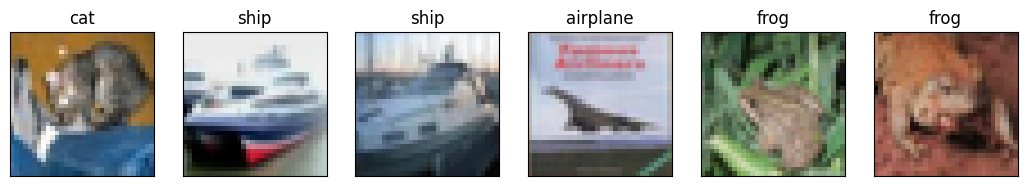

GroundTruth:  ['cat'] ['ship'] ['ship'] ['airplane'] ['frog'] ['frog']
Predicted:  ['cat'] ['ship'] ['truck'] ['airplane'] ['frog'] ['frog']


In [30]:
import d2l
dataiter = iter(test_iter) #创建无预处理的测试加载器的迭代器
images, labels = next(dataiter) #返回batch_size幅图片与标签，即6幅图片images与标签labels
show_cifar10(images, get_CIFAR10_labels(labels))#展示测试集的这六幅图片与标签

print('GroundTruth: ', ' '.join('%5s' % get_CIFAR10_labels([labels[j].numpy()]) for j in range(6)))#打印真实的标签GroundTruth
dataiter_tran = iter(test_iter_tran) #创建有预处理测试集的测试加载器的迭代器
images_tran, labels_tran = next(dataiter_tran)#返回batch_size幅图片与标签，即6幅图片images与标签labels
images_tran=images_tran.to(device) #将图片搬移至GPU
labels_tran=labels_tran.to(device) #将标签搬移至GPU
outputs = net(images_tran) #将有预处理的测试集批量图片输入已经训练好的网络模型,输出批量预测数据outputs
_, predicted = torch.max(outputs.data, 1) #得到批量预测数据outputs.data的最大值索引predicted列表
print('Predicted: ', ' '.join('%5s' % get_CIFAR10_labels([predicted[j].cpu().numpy()]) for j in range(6)))#打印预测的标签Predicted
